# <center> Прогнозирование давления в дыхательных путях.

## 1. Постановка задачи

<center> <img src=http://www.sechenov.ru/upload/iblock/90c/7.jpg align="right" width="300"/> </center>
Что делают врачи, когда у пациента проблемы с дыханием? Они используют аппарат ИВЛ, чтобы накачать кислород в легкие пациента, находящегося под действием седативных средств, через трубку в дыхательном горле. Но искусственная вентиляция легких — это процедура, требующая большого количества клиницистов, и это ограничение было заметно в первые дни пандемии COVID-19. В то же время разработка новых методов управления аппаратами ИВЛ непомерно дорога, даже до клинических испытаний. Качественные симуляторы могли бы уменьшить этот барьер.

Существующие симуляторы обучаются как ансамбль, где каждая модель имитирует состояние одного легкого. Однако легкие и их атрибуты образуют непрерывное пространство, поэтому необходимо изучить параметрический подход, учитывающий различия в легких пациентов.

В партнерстве с Принстонским университетом команда Google Brain стремится расширить сообщество вокруг машинного обучения для управления механической вентиляцией. Они считают, что машинное обучение может лучше обобщать легкие с различными характеристиками, чем текущий отраслевой стандарт ПИД-контроллеров.

В этом проекте имитирована работа вентилятора, подключенного к легкому пациента, находящегося под действием седативных средств. Данные вентилятора, используемые в этом проекте, были получены с использованием модифицированного вентилятора с открытым исходным кодом, подключенного к искусственному сильфонному тестовому легкому через дыхательный контур. 

На приведенной ниже диаграмме показана установка, где два управляющих входа выделены зеленым цветом, а переменная состояния (давление в дыхательных путях) для прогнозирования выделена синим цветом. Первый управляющий вход представляет собой непрерывную переменную от 0 до 100, представляющую процентную долю открытия электромагнитного клапана вдоха для поступления воздуха в легкие (т. е. 0 полностью закрыт и воздух не поступает, а 100 полностью открыт). Второй управляющий вход представляет собой двоичную переменную - открыт ли исследовательский клапан (1) или закрыт (0) для выпуска воздуха.

<img src=https://raw.githubusercontent.com/google/deluca-lung/main/assets/2020-10-02%20Ventilator%20diagram.svg>

**Цель проекта - создать модель для прогноза давления в дыхательных путях во время дыхания, учитывая временные ряды управляющих воздействий.**

## 2. Знакомство с данными, базовый анализ

In [1]:
# для работы с таблицами
import pandas as pd

# для визуализации
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import optuna
import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense

import pickle
from sklearn.pipeline import Pipeline

e:\python\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Загрузим данные:

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


**Описание признаков:**
* id - идентификатор временного шага для всего файла.
* breath_id - идентификатор испытуемого лёгкого.
* R - атрибут легких, указывающий, насколько ограничены дыхательные пути (в cmH2O/L/S). Физически это изменение давления на изменение расхода воздуха (объем воздуха за время). Образно можно представить себе надувание воздушного шара через соломинку - мы можем изменить R, изменив диаметр соломинки, при этом чем выше R, тем труднее надувать шар. 
* C - атрибут легкого, указывающий, насколько легкое податливо (в мл/смH2O). Физически это изменение объема на изменение давления. Образно можно представить тот же пример с воздушным шаром. Мы можем изменить C, изменив толщину латекса воздушного шара, при этом чем выше C, тем тоньше латекс, и его легче надувать.
* time_step - отметка времени.
* u_in - управляющий вход электромагнитного клапана вдоха.
* u_out - управляющий вход для исследовательского электромагнитного клапана.
* pressure - Целевая переменная. Давление в дыхательных путях, измеренное в дыхательном контуре, измеренное в смH2O.

Проверим наличие пропусков в данных:

In [4]:
df.isna().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64

Отлично, пропусков в данных нет. Разберемся как устроенна структура данных, посмотрим на значения признака breath_id:

In [5]:
df['breath_id'].value_counts()

1         80
83891     80
83924     80
83923     80
83922     80
          ..
41745     80
41743     80
41742     80
41741     80
125749    80
Name: breath_id, Length: 75450, dtype: int64

Видим, что для каждого испутаемого лёгкого присутствует по 80 записей. Проверим есть ли такие breath_id для которых кол-во записей отличается:

In [6]:
df['breath_id'].value_counts().describe()

count    75450.0
mean        80.0
std          0.0
min         80.0
25%         80.0
50%         80.0
75%         80.0
max         80.0
Name: breath_id, dtype: float64

Как видно для каждого лёгкого есть ровно по 80 записей. Посмотрим на сами значения признака breath_id:

In [7]:
df['breath_id'].describe()

count    6.036000e+06
mean     6.283886e+04
std      3.633526e+04
min      1.000000e+00
25%      3.137700e+04
50%      6.276550e+04
75%      9.430100e+04
max      1.257490e+05
Name: breath_id, dtype: float64

Как видно количество уникальных id - 75450, но максимальное значение id - 125749, это значит  что значения breath_id не обязательно идут по порядку и могут иметь уникальные независимые значения, впрочем этот никак не влияет на распределение данных в таблице, просто в дальнейшем будем иметь это ввиду.

Посмотрим на временные интервалы для типов лёгких:

In [8]:
df[df['breath_id'] == 1]['time_step']

0     0.000000
1     0.033652
2     0.067514
3     0.101542
4     0.135756
        ...   
75    2.553593
76    2.587754
77    2.621773
78    2.655746
79    2.689766
Name: time_step, Length: 80, dtype: float64

Посмотрим на значения признака time_step: 

In [9]:
df['time_step'].describe()

count    6.036000e+06
mean     1.307225e+00
std      7.659778e-01
min      0.000000e+00
25%      6.428995e-01
50%      1.308123e+00
75%      1.965502e+00
max      2.937238e+00
Name: time_step, dtype: float64

Максимальное значение - 2.9 секунды, значит на каждое лёгкое приходится временноё интервал до 2.9 секунд.

Итак, структура данных устроена так: для каждого лёгкого сделано по 80 записей, что соответствует временному интервалу до трёх секунд, записи в таблице идут последовательно и содержат информацию о 75450 образцов лёгких.

Посмотрим какие значения принимают остальные признаки:

In [10]:
df['R'].value_counts(normalize=True)

50    0.399284
5     0.329490
20    0.271226
Name: R, dtype: float64

В данных почти в равном количестве представлены три типа атрибута R.

In [11]:
df['C'].value_counts(normalize=True)

10    0.371889
50    0.326653
20    0.301458
Name: C, dtype: float64

Также почти в равном количестве предаставлены данные о трёх разных типах атрибута C.

In [12]:
df['u_in'].describe()

count    6.036000e+06
mean     7.321615e+00
std      1.343470e+01
min      0.000000e+00
25%      3.936623e-01
50%      4.386146e+00
75%      4.983895e+00
max      1.000000e+02
Name: u_in, dtype: float64

Как и сказано в описании данных параметр входного клапана u_in изменяется от 0 до 100.

In [13]:
df['u_out'].value_counts(normalize=True)

1    0.620449
0    0.379551
Name: u_out, dtype: float64

Признак u_out является бинарной переменной и принимает значения 0 и 1.

In [14]:
df['pressure'].describe()

count    6.036000e+06
mean     1.122041e+01
std      8.109703e+00
min     -1.895744e+00
25%      6.329607e+00
50%      7.032628e+00
75%      1.364103e+01
max      6.482099e+01
Name: pressure, dtype: float64

Как видно значение давления может принимать отрицательные значения. Посмотрим на эти данные подробнее:

In [15]:
df[df['pressure'] < 0]

,id,breath_id,R,C,time_step,u_in,u_out,pressure
28720,28721,542,50,10,0.000000,0.000000,0,-1.825442
28721,28722,542,50,10,0.033468,0.074189,0,-1.825442
28722,28723,542,50,10,0.066892,0.143197,0,-1.755140
28723,28724,542,50,10,0.100245,0.208192,0,-1.825442
28724,28725,542,50,10,0.133618,0.268278,0,-1.684838
...,...,...,...,...,...,...,...,...
5979915,5979916,124575,50,10,2.504311,0.057006,1,-0.700608
5979916,5979917,124575,50,10,2.537637,0.057709,1,-0.770910
5979917,5979918,124575,50,10,2.570976,0.058412,1,-0.841212
5979918,5979919,124575,50,10,2.604315,0.057709,1,-0.770910


Таких данных немало - вряд ли это выбросы.

Признаков в таблице не так много и из них вряд ли получится создать новые признаки, так что перейдём к разведывательному анализу.

## 3. Разведывательный анализ данных (EDA)

Для начала посмотрим как выглядит временной ряд давления для одного из типов лёгкого(breath_id):

In [16]:
fig = px.line(df[df['breath_id']==1], x="time_step", y="pressure", title='Временной ряд давления (breath_id=1)')
fig.show()

Видно, что с начала давление растёт, а потом резко снижается, скорее всего это зависит от положения клапана (u_out), выделим на графике разные положения клапана:

In [17]:
fig = px.line(df[df['breath_id']==1], x="time_step", y="pressure", title='Давление при разных положениях клапана',color='u_out')
fig.show()

Да, давление резко падает при открытии клапана u_out.

Посмотрим на еще один временной ряд для сравнения:

In [18]:
fig = px.line(df[df['breath_id']==7], x="time_step", y="pressure", title='Временной ряд давления (breath_id=7)')
fig.show()

Этот временной ряд заметно отличается от предыдущего, посмотрим на временной ряд значения входного клапана(u_in):

In [19]:
fig = px.line(df[df['breath_id']==7], x="time_step", y=["u_in",'pressure'], title='Временной ряд u_in и pressure')
fig.show()

Видно, что давление напрямую зависит от значения входного клапана u_in. Несмторя на то, что после 1.5 секунды значение u_in растёт - тренд давления не меняется, видимо это связано с тем, что выходной клапан u_out открыт и давление не может увеличиваться.

Призники id и breath_id не несут в себе полезной информации, удалим их:

In [20]:
df = df.drop(['id','breath_id'],axis=1)

Построим тепловую карту корреляции признаков: 

In [21]:
fig = px.imshow(df.corr(),text_auto=True, aspect="auto")
fig.show()

Видна высокая корреляция между u_out и time_step - не удивительно, как видно из графиков выше - клапан переключается во второй половине временного интервала и соответственно напрямую зависит от времени.
Корреляция между давлением и параметрами R и C практически отсутствует. Максимальное же значение на целевую переменную оказывают признаки u_out и time_step.

Итак, стало яснее как выглядят данные и зависят друг от друга. Перейдём к машинному обучению.

## 4. Подготовка данных

Разделим данные на тренировочную  и тестовую выборки:

In [22]:
#X - матрица наблюдений, y - столбец правильных ответов
X = df.drop('pressure', axis=1)
y = df['pressure']

#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=100 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (4828800, 5)
Test shape: (1207200, 5)


Для лучших результатов обучения нормализируем данные: 

In [23]:
#Создаем объект для min-max нормализации
scaler = MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Определимся с метрикой - будем использовать среднюю абсолютную ошибку(MAE) так как её легко интерпретировать, а также коэффициент детерминации R^2. 

Для удобства напишем функцию вычисления метрик:

In [24]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))

## 5. Машинное обучение (ML)

### Линейная регрессия и деревья 

Начнём с простых моделей, обучим простую линейную регрессию: 

In [25]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель
lr.fit(X_train_scaled, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.384
Train MAE: 3.950


Test R^2: 0.384
Test MAE: 3.944


Метрики на тренировачной и тестовой выборках почти не отличаются, что говорит об отсутствии переобучения. Но сами метрики могут быть и лучше. Попробуем создать полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn и обучить модель заново:

In [26]:
#создаём полиомиальные признаки
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
#добавляем признаки в наборы данных
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
#вывыдем кол-во полученных признаков
print('Train shape: {}'.format(X_train_poly.shape))
print('Test shape: {}'.format(X_test_poly.shape))
#обучаем модель на новых данных
lr.fit(X_train_poly, y_train)
#предсказываем целевые переменные
y_train_pred = lr.predict(X_train_poly)
y_test_pred = lr.predict(X_test_poly)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train shape: (4828800, 20)
Test shape: (1207200, 20)
Train R^2: 0.571
Train MAE: 3.140


Test R^2: 0.571
Test MAE: 3.137


В итоге регрессия обучилась на 20 признаках, что заметно улучшило метрики. Посмотрим как справится с задачей дерево решений:

In [27]:
#инициализируем дерево решений(все параметры по умолчанию)
dt = DecisionTreeRegressor()
#обучаем и предсказываем y
dt.fit(X_train_scaled, y_train)
y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.979
Train MAE: 0.191


Test R^2: 0.611
Test MAE: 2.395


Метрики на обучающей выборке - превосходные, но на тестовой заметно хуже. Диагноз - дерево переобучилось. Подберём оптимальную глубину дерева:

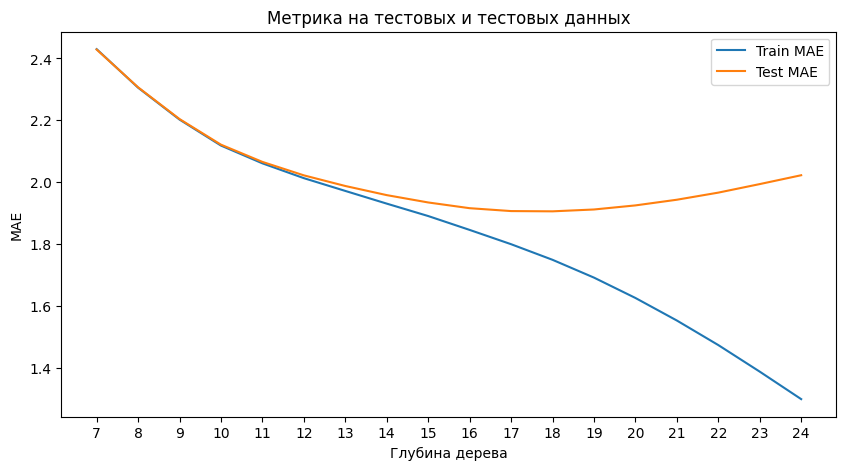

In [28]:
#списки для метрик
train_list = []
test_list = []
#диапазон изменения глубины дерева
depth_step = range(7,25)
#перебираем глубины дерева и добавляем в списки метрики
for i in depth_step:
    dt = DecisionTreeRegressor(max_depth=i)
    dt.fit(X_train_scaled, y_train)
    y_train_pred = dt.predict(X_train_scaled)
    y_valid_pred = dt.predict(X_test_scaled)
    train_list.append(metrics.mean_absolute_error(y_train,y_train_pred))
    test_list.append(metrics.mean_absolute_error(y_test,y_valid_pred))
    
#Визуализируем метрики при различных max_depth
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(depth_step, train_list, label='Train MAE')
ax.plot(depth_step, test_list, label='Test MAE')
#Даем графику название и подписи осям
ax.set_title('Метрика на тестовых и тестовых данных')
ax.set_xlabel('Глубина дерева')
ax.set_ylabel('MAE')
ax.set_xticks(depth_step)
ax.legend();

Из графика видно, что оптимальной глубиной будет 18 - метрика на тренировачных данных продолжает снижаться, а на валидационных еще не начинает расти. Посмотрим чему равны метрики с такой глубиной дерева:

In [40]:
dt = DecisionTreeRegressor(max_depth=18)
#обучаем и предсказываем y
dt.fit(X_train_scaled, y_train)
y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.804
Train MAE: 1.749


Test R^2: 0.772
Test MAE: 1.906


### Ансамблевые методы

Переходим от простых моделей к более сложным - ансамблевым методам.

Воспользуемся моделью случайного леса. Для оптимизации гиперпараметров модели применим библиотеку optuna:

In [ ]:
# поиск гиперпараметров обернём в функцию
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 50, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 20, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель случайного леса
  model = RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.mean_absolute_error(y_train, model.predict(X_train_scaled))

  return score

%%time
# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestRegressor")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)
#ВНИМАНИЕ! расчёт может занять несколько часов!

Поиск гиперпараметров на таком кол-ве данных очень долгая процедура. С помошью optuna были получены оптимальны параметры модели - {'n_estimators': 179, 'max_depth': 19, 'min_samples_leaf': 2}. Обучим отдельно модель с этими параметрами: 

In [11]:
# инициализируем модель 
rf = RandomForestRegressor(max_depth=19,n_estimators=179, random_state=42, min_samples_leaf=2)
# обучаем
rf.fit(X_train_scaled, y_train)
# делаем предсказание
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)
# выводим метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.820
Train MAE: 1.689


Test R^2: 0.789
Test MAE: 1.844


Обучение модели с таким кол-вом деревьев заняло немало времени, но метрику удалось слегка улучшить.

Попробуем более быструю модель - экстремальный градиентный бустинг:

In [12]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.2, 'colsample_bytree': 0.9, 
            'max_depth': 18, 'subsample': 0.5, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'mae', 'objective': 'reg:absoluteerror'
           }
# Тренировочная и тестовая выборка
watchlist = [(dtrain, 'train'), (dtest, 'test')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10, #шаг, через который происходит отображение метрик
    early_stopping_rounds=20 #раняя остановка
)

[0]	train-mae:3.12761	test-mae:3.12321
[10]	train-mae:1.94151	test-mae:1.96411
[20]	train-mae:1.87966	test-mae:1.91038
[30]	train-mae:1.86460	test-mae:1.89927
[40]	train-mae:1.85538	test-mae:1.89627
[50]	train-mae:1.85054	test-mae:1.89457
[60]	train-mae:1.84912	test-mae:1.89459
[70]	train-mae:1.84678	test-mae:1.89336
[80]	train-mae:1.84573	test-mae:1.89301
[90]	train-mae:1.84475	test-mae:1.89320
[100]	train-mae:1.84419	test-mae:1.89405
[101]	train-mae:1.84418	test-mae:1.89409


Обучение модели на порядок быстрее, но метрика чуть хуже. На последок попробуем нейронную сеть.

### Нейронная сеть

Будем ипользовать модуль tensorflow, в котором реализовано много полезных методов для имплементации нейронных сетей:

In [14]:
# Инициализируем модель
model= Sequential()

# Создаём слои и задаём кол-во нейронов
model.add(Dense(units=64,activation='relu',input_shape=[5]))
model.add(Dense(units=64,activation='relu'))
model.add(Dense(units=64,activation='relu'))
model.add(Dense(units=1))

# задаём алгоритм оптимизации и метрику
model.compile(loss='mean_absolute_error',optimizer='Adam',metrics='mean_absolute_error')

# обучаем нейронку на пяти итерациях 
model.fit(X_train_scaled,y_train,batch_size=100,epochs=5)

Epoch 1/5
48288/48288 [==============================] - 62s 1ms/step - loss: 2.2820 - mean_absolute_error: 2.2820
Epoch 2/5
48288/48288 [==============================] - 64s 1ms/step - loss: 2.1208 - mean_absolute_error: 2.1208
Epoch 3/5
48288/48288 [==============================] - 63s 1ms/step - loss: 2.0959 - mean_absolute_error: 2.0959
Epoch 4/5
48288/48288 [==============================] - 63s 1ms/step - loss: 2.0839 - mean_absolute_error: 2.0839
Epoch 5/5
48288/48288 [==============================] - 54s 1ms/step - loss: 2.0762 - mean_absolute_error: 2.0762


Метрика заметно ниже чем у случайного леса, так что остановимся именно на RandomForest.

Давайте для наглядности посторим предсказанный временной ряд и сравним его с исходным:

In [62]:
# предсказываем значения давления для первого типа лёгких
predit_pressure = rf.predict(scaler.transform(df[['R','C','time_step','u_in','u_out']].iloc[0:80]))
# строим график для исходных и предсказанных данных
fig = px.line(df.iloc[0:80], x="time_step", y=["pressure",predit_pressure ], title='Предсказанный временной ряд')
fig.show()

Как видим модель достаточно точно улавливает тренд временного ряда.

Осталось подготовить модель для дальнейшего продакшана. 

## 6. Сериализация модели и подготовка пайплайна

Сериализуем модель с помощью pickle:

In [80]:
# Производим сериализацию и записываем результат в файл формата pkl
with open('ventilator_pressure_prediction_model.pkl', 'wb') as output:
    pickle.dump(rf, output)

Для удобстав обернём ход решения в пайплайн:

In [ ]:
# для удаления столбцов создадим кастомный трансформер
class columnDropperTransformer():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self 
      
# Создаём пайплайн, который включает нормализацию, отбор признаков и обучение модели
pipeline = Pipeline([
  ('columnDropper',columnDropperTransformer(['id','breath_id'])),  
  ('Scaling', MinMaxScaler()),
  ('RandomForestRegressor', RandomForestRegressor(max_depth=19,n_estimators=179, random_state=42, min_samples_leaf=2))
  ])
pipeline.fit(X,y)

## 7. Результаты

* В данном проекте было получено 6036000 записей о работе вентилятора для лёгких. Данные были подробно изучены - в них присутствуют 75450 временных рядов для разных типов лёгких и разных воздествий на них. 
* Сами данные качествено подготовлены - не обаружено пропусков или выбросов. Так что в качестве предобработки данных были удалены неинформативные признаки и произведена нормализация данных. 
* Были испробованы следующие модели машинного обучения(оценка качества - MAE):

    * Линейная регрессия с параметрами по умолчанию - MAE = 3.944
    * Линейная регрессия, но обученная на полиномиальных признаках 2-ой степени - MAE = 3.137
    * Дерево решений с подобраной оптимальной глубиной - MAE = 1.906
    * Случайный лес с оптимизированными гиперпараметрами - MAE = 1.844
    * Экстремальный градиентный бустинг - MAE = 1.893
    * Нейронная сеть с тремя слоями обучения - MAE = 2.076
#
* Лучший результат показала модель случайного леса, но обучение этой модели заняло очень много времени. Модель экстремального бустинга показала результат несильно хуже, но время обучения гораздно меньше. Выбор был сделан в пользу большей точности, так что для дальшейшего продакшана модели был использован имеено случайный лес.
* Для наглядности был построен предсказанный временной ряд давления и сравнен с исходными данными. Модель показала неплохую предсказательную способность. 
* Модель была сериализована для дальнейшего использования, а ход решения для удобства обёрнут в пайплайн.     